In [1]:
%matplotlib inline

import glob
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.table import Table, Column

from desispec.interpolation import resample_flux

mpl.rc('font', family='serif', size=10)

In [2]:
# Some simulation parameters
night   = '20190401' # default is current date
expid   = 1 # exposure ID number, can use to simulate more than one DESI exposure

simspecfile = '/Users/ryanrubenzahl/Documents/DESI/spectro/sim/example/{0:s}/simspec-{1:08d}.fits'.format(night, expid)
print('Reading simspec file {}.'.format(simspecfile))
hdu = fits.open(simspecfile)
# hdu.info()
meta = Table(hdu['TRUTH'].data)
hdu.close()
meta[:5]

Reading simspec file /Users/ryanrubenzahl/Documents/DESI/spectro/sim/example/20190401/simspec-00000001.fits.


OBJTYPE,SUBTYPE,TEMPLATEID,SEED,REDSHIFT,MAG,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,OIIFLUX,HBETAFLUX,EWOII,EWHBETA,D4000,VDISP,OIIDOUBLET,OIIIHBETA,OIIHBETA,NIIHBETA,SIIHBETA,ZMETAL,AGE,TEFF,LOGG,FEH
str10,str10,int32,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
ELG,,4153,3244113739,1.31718,22.7025,0.70432,0.829886,1.90889,2.67739,2.28649,5.29778e-17,-1.0,34.9565,-1.0,1.06329,112.563,0.733237,-0.0850786,0.275525,-0.248196,-0.19466,-1.0,-1.0,-1.0,-1.0,-1.0
ELG,,2688,3952505139,1.2662,22.4236,0.878645,1.07286,2.4001,6.84587,6.11047,1.08926e-16,-1.0,48.878,-1.0,1.1127,51.1561,0.757255,-0.00885063,0.630011,-0.265495,-0.230491,-1.0,-1.0,-1.0,-1.0,-1.0
ELG,,6611,369720621,1.43109,22.6999,0.858529,0.831816,1.4501,4.56679,4.52627,2.92787e-17,-1.0,19.515,-1.0,1.12851,108.133,0.698619,-0.00354248,0.468131,-0.177077,-0.244851,-1.0,-1.0,-1.0,-1.0,-1.0
ELG,,3036,1380208214,0.810496,22.8491,0.455627,0.725066,1.46547,2.40354,1.55259,4.61445e-17,-1.0,30.208,-1.0,1.04986,69.5767,0.768562,-0.259912,0.359219,-0.192721,-0.321941,-1.0,-1.0,-1.0,-1.0,-1.0
ELG,,339,3715951850,1.57732,23.0862,0.530935,0.582797,0.772629,3.17812,3.69367,1.14989e-16,-1.0,141.638,-1.0,1.08143,56.773,0.695933,0.99763,-0.176836,-1.62771,-0.851503,-1.0,-1.0,-1.0,-1.0,-1.0


In [3]:
from collections import Counter

Counter(meta['OBJTYPE'])

Counter({'ELG': 900, 'FSTD': 20, 'SKY': 80})

In [4]:
galaxies = sorted(glob.glob('./galaxy_sim_catalog/gal_spectra/*.fits'))
print len(galaxies), "spectra"

4000 spectra


## Read in all the spectra into a table

In [11]:
spec_table = Table(names=('OBJTYPE', 'HAS_SN', 'REDSHIFT', 
                         'WAVE', 'FLUX', 'IVAR'),
                 dtype=('S4', 'S5', float, list, list, list))

In [12]:
for n, galaxy in enumerate(galaxies):
        
    with fits.open(galaxy, memmap=0) as hdul:
        
        objtype = hdul[0].header['OBJTYPE']
        has_sn  = hdul[0].header['HAS_SN']
        Z    = hdul[0].header['REDSHIFT']
        wave = hdul[1].data / (Z+1)
        flux = hdul[2].data
        ivar = hdul[3].data
        
        new_row = [objtype, has_sn, Z, wave, flux, ivar]
        spec_table.add_row(new_row)

In [13]:
spec_table[:10]

OBJTYPE,HAS_SN,REDSHIFT,WAVE,FLUX,IVAR
str4,str5,float64,object,object,object
ELG,False,1.31717848778,"[ 1540.32154622 1540.75310556 1541.18466489 ..., 4243.17774706 4243.6093064 4244.04086573]","[ 2.97667265 -6.38240242 10.06769371 ..., 0.96142119 0.07974409 -2.26469016]","[ 0.01082826 0.03107381 0.03433616 ..., 3.6888268 3.67129278 0.18508758]"
ELG,False,1.26619613171,"[ 1574.97398448 1575.41525256 1575.85652063 ..., 4338.6360332 4339.07730127 4339.51856934]","[ 21.09259033 -3.63471913 -3.62161207 ..., -0.50702488 -0.23013815 3.66119075]","[ 0.01086412 0.03117194 0.03443619 ..., 3.63954163 3.62984538 0.18316205]"
ELG,False,1.43109238148,"[ 1468.14657409 1468.55791182 1468.96924954 ..., 4044.35482182 4044.76615954 4045.17749726]","[ 2.1587534 -0.24877414 -4.98826885 ..., 0.88626754 0.62245953 5.80315638]","[ 0.01171295 0.0336103 0.03713416 ..., 4.59751606 4.57700062 0.23076914]"
ELG,False,0.810495615005,"[ 1971.39386673 1971.94620168 1972.49853663 ..., 5430.66777617 5431.22011112 5431.77244607]","[-0.56138337 0.56115466 2.43574619 ..., 0.12035236 0.75067896 -1.46901035]","[ 0.01243379 0.03567722 0.03941667 ..., 4.71382093 4.70315695 0.23736048]"
ELG,False,1.57731938362,"[ 1384.84969067 1385.2376907 1385.62569073 ..., 3814.89397775 3815.28197778 3815.66997781]","[-11.43706322 -0.47788131 16.32930183 ..., -0.18508507 0.52385384 -2.31497431]","[ 0.01249165 0.03584334 0.03960004 ..., 4.36889172 4.36528397 0.22045511]"
ELG,False,1.16381049156,"[ 1649.49747914 1649.95962682 1650.4217745 ..., 4543.92851576 4544.39066344 4544.85281112]","[ 6.69515467 3.44517708 -0.24241585 ..., -0.59038848 0.53775698 -3.11528778]","[ 0.01081544 0.03103586 0.03428994 ..., 4.22747946 4.20404577 0.21186534]"
ELG,False,0.685532093048,"[ 2117.55087067 2118.14415513 2118.73743959 ..., 5833.29159727 5833.88488174 5834.4781662 ]","[ 0.48312631 -8.45000172 -2.34389114 ..., -0.068896 0.78127056 1.10531056]","[ 0.01203065 0.03452161 0.03814146 ..., 4.47378254 4.45968437 0.22498453]"
ELG,False,1.42798101902,"[ 1470.02794635 1470.43981119 1470.85167602 ..., 4049.53750391 4049.94936875 4050.36123358]","[-7.99691248 -2.73930001 -2.73470473 ..., 0.34630153 1.04012191 0.61926657]","[ 0.01143005 0.03279713 0.03623426 ..., 4.18948984 4.18374968 0.21123911]"
ELG,False,1.31413567066,"[ 1542.34688848 1542.77901526 1543.21114205 ..., 4248.75702836 4249.18915515 4249.62128193]","[-2.89712334 3.48677945 -1.03960502 ..., 0.53309172 0.87795806 -0.33148646]","[ 0.01168938 0.03354295 0.03706102 ..., 4.37515974 4.33334351 0.21798679]"


## Plots of Spectra

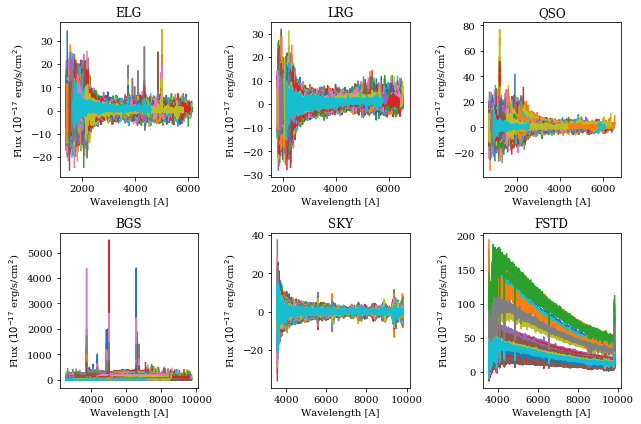

In [34]:
fig, ax = plt.subplots(2,3, figsize=(9, 6))
axes = {'ELG':  [0,0], 
        'LRG':  [0,1], 
        'QSO':  [0,2],
        'BGS':  [1,0],
        'SKY':  [1,1], 
        'FSTD': [1,2]}

redshifts = {}
allobjs = []
for obj in axes:

    i, j = axes[obj]
    for spectra in spec_table[spec_table['OBJTYPE']==obj]:
        
        Z = spectra['REDSHIFT']
        wave = spectra['WAVE']
        flux = spectra['FLUX']

        ax[i,j].plot(wave, flux)
        
    ax[i,j].set_title(obj)
    ax[i,j].set_xlabel('Wavelength [A]')
    ax[i,j].set_ylabel('Flux ($10^{-17}$ erg/s/cm$^2$)')
            
# ax.margins(0)
fig.tight_layout()

# plt.savefig('plots/simulated_galaxies.png', format='png', 
#             dpi=300, bbox_inches='tight')

In [17]:
from collections import Counter

# counts = Counter(allobjs)
counts = Counter(gal_table['OBJTYPE'])

print [(v, k) for v, k in zip(counts.values(), counts.keys())]

[(80, 'FSTD'), (900, 'LRG'), (320, 'SKY'), (900, 'QSO'), (900, 'ELG'), (900, 'BGS')]


## Redshift Distribution

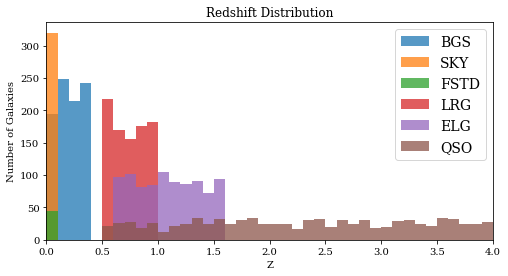

In [25]:
fig, ax = plt.subplots(1,1, figsize=(8, 4))

# for objtype in ['LRG', 'ELG', 'QSO']:
for objtype in ['BGS', 'SKY', 'FSTD', 'LRG', 'ELG', 'QSO']:
    ax.hist(spec_table[spec_table['OBJTYPE']==objtype]['REDSHIFT'], range=(0,4), bins=40, alpha=0.75, label=objtype)
    
ax.set(title='Redshift Distribution',
       xlabel='Z', xlim=[0,4],
       ylabel='Number of Galaxies')
ax.legend(loc='best', fontsize=14)
# plt.savefig('plots/redshift_distribution.png', format='png', 
#             dpi=300, bbox_inches='tight')

## Random Forest Classifier

In [40]:
# # Get all the metadata
# objtypes = ['ELG', 'LRG', 'QSO', 'BGS']
# metatables = []

# for i in range(len(objtypes)):
#     expid = i + 1
#     simspecfile = '/Users/ryanrubenzahl/Documents/DESI/spectro/sim/example/{0:s}/simspec-{1:08d}.fits'.format(night, expid)
#     print('Reading simspec file {}.'.format(simspecfile))
#     hdu = fits.open(simspecfile)
#     # hdu.info()
#     meta = Table(hdu['TRUTH'].data)
#     hdu.close()
    
#     metatables.append(meta)
    
# from astropy.table import vstack
# metadata = vstack(metatables)

Reading simspec file /Users/ryanrubenzahl/Documents/DESI/spectro/sim/example/20190329/simspec-00000001.fits.
Reading simspec file /Users/ryanrubenzahl/Documents/DESI/spectro/sim/example/20190329/simspec-00000002.fits.
Reading simspec file /Users/ryanrubenzahl/Documents/DESI/spectro/sim/example/20190329/simspec-00000003.fits.


In [41]:
# metadata[123]

OBJTYPE,SUBTYPE,TEMPLATEID,SEED,REDSHIFT,MAG,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,OIIFLUX,HBETAFLUX,EWOII,EWHBETA,D4000,VDISP,OIIDOUBLET,OIIIHBETA,OIIHBETA,NIIHBETA,SIIHBETA,ZMETAL,AGE,TEFF,LOGG,FEH
str10,str10,int32,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
LRG,,32,1860001255,0.869868,19.6775,0.324068,2.4224,13.4584,52.256,33.9515,-1.0,-1.0,-1.0,-1.0,1.69631,207.749,-1.0,-1.0,-1.0,-1.0,-1.0,0.0096,6.30957,-1.0,-1.0,-1.0


In [27]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

In [26]:
allwaves = np.concatenate(spec_table['WAVE'])
min_wave = np.min(allwaves)
max_wave = np.max(allwaves)

print min_wave, max_wave

step= 1.0 # A
global_wavelength_grid = np.arange(min_wave, max_wave+step, step)
print global_wavelength_grid

714.453619508 9842.5739314
[  714.45361951   715.45361951   716.45361951 ...,  9841.45361951
  9842.45361951  9843.45361951]


In [30]:
# Resample spectra to a common wavelength grid
resample_fluxes = []
for spectra in spec_table:
    wave = spectra['WAVE']
    flux = spectra['FLUX']
    ivar = spectra['IVAR']
    spec_flux_resample, spec_ivar_resample = resample_flux(
                                 global_wavelength_grid, wave, 
                                 flux, ivar=ivar, extrapolate=False
                                )
    resample_fluxes.append(spec_flux_resample)
    
spec_table['RESAMPLED_FLUX'] = resample_fluxes

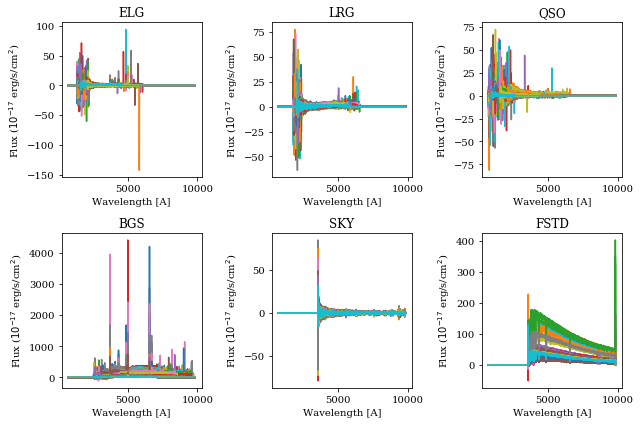

In [35]:
fig, ax = plt.subplots(2,3, figsize=(9, 6))
axes = {'ELG':  [0,0], 
        'LRG':  [0,1], 
        'QSO':  [0,2],
        'BGS':  [1,0],
        'SKY':  [1,1], 
        'FSTD': [1,2]}

for obj in axes:

    i, j = axes[obj]
    for spectra in spec_table[spec_table['OBJTYPE']==obj]:
        
        resampled_flux = spectra['RESAMPLED_FLUX']

        ax[i,j].plot(global_wavelength_grid, resampled_flux)
        
    ax[i,j].set_title(obj)
    ax[i,j].set_xlabel('Wavelength [A]')
    ax[i,j].set_ylabel('Flux ($10^{-17}$ erg/s/cm$^2$)')
        
# ax.margins(0)
fig.tight_layout()

# plt.savefig('plots/resampled_redshifted_galaxies.png', format='png', 
#             dpi=300, bbox_inches='tight')

In [39]:
# Load resampled spectrum data into one overall table
# each column will be one bin in the global wavelength grid
table  = []
names  = []
dtypes = []

# for i in range(len(fluxes)):
#     tablerow = np.append(fluxes[i], objtypes[i])
for i in range(len(resample_fluxes)):
    tablerow = np.append(spec_table['RESAMPLED_FLUX'][i], spec_table['OBJTYPE'][i])
    table.append(tablerow)

# for i in range(len(waves[0])):
for i in range(len(global_wavelength_grid)):
    names.append("w%d" % i)
    dtypes.append(np.float32)
    
names.append('OBJTYPE')
dtypes.append('S')

data = Table(rows=table, names=names, dtype=dtypes)

In [40]:
df = data.to_pandas()

In [41]:
df[:5]

,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,...,w9121,w9122,w9123,w9124,w9125,w9126,w9127,w9128,w9129,OBJTYPE
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ELG
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ELG
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ELG
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ELG
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ELG


In [42]:
df['is_train'] = np.random.uniform(0, 1, len(df)) <= 0.75

In [43]:
# We now split the dataframes into a test and training dataset
train, test = df[df['is_train']==True], df[df['is_train']==False]
print 'Number of observations in the training data:', len(train)
print 'Number of observations in the test data:',len(test)

Number of observations in the training data: 3030
Number of observations in the test data: 970


In [44]:
train_count = Counter(train['OBJTYPE'])
print [(v, k) for v, k in zip(train_count.values(), train_count.keys())] 

test_count = Counter(test['OBJTYPE'])
print [(v, k) for v, k in zip(test_count.values(), test_count.keys())] 

[(64, 'FSTD'), (675, 'LRG'), (241, 'SKY'), (689, 'QSO'), (683, 'ELG'), (678, 'BGS')]
[(16, 'FSTD'), (225, 'LRG'), (79, 'SKY'), (211, 'QSO'), (217, 'ELG'), (222, 'BGS')]


In [45]:
features = df.columns[:-2]
features

Index([u'w0', u'w1', u'w2', u'w3', u'w4', u'w5', u'w6', u'w7', u'w8', u'w9',
       ...
       u'w9120', u'w9121', u'w9122', u'w9123', u'w9124', u'w9125', u'w9126',
       u'w9127', u'w9128', u'w9129'],
      dtype='object', length=9130)

In [46]:
# train['species'] has the "true" species names
# in order to compare later it needs to be coded into integers (0, 1, 2)

y, objtypes = pd.factorize(train['OBJTYPE'])

# Now we train the random forest
clf = RandomForestClassifier(n_jobs=2, random_state=0)

clf.fit(train[features], y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=2, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [47]:
# Apply the classifier to the test data
clf.predict(test[features])

array([0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 3, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 4, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3,
       0, 3, 1, 3, 1, 3, 3, 2, 3, 3, 2, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3,
       3, 3,

In [48]:
# Convert back to english
preds = [objtypes[i] for i in clf.predict(test[features])]

In [49]:
from pandas_ml import ConfusionMatrix

cm = ConfusionMatrix(test['OBJTYPE'].tolist(), preds)
cm.print_stats()

Confusion Matrix:

Predicted  BGS  ELG  FSTD  LRG  QSO  SKY  __all__
Actual                                           
BGS        222    0     0    0    0    0      222
ELG          0  213     0    3    1    0      217
FSTD         0    0    16    0    0    0       16
LRG          0    4     0  220    1    0      225
QSO          0   32     0    1  178    0      211
SKY          0    0     0    0    0   79       79
__all__    222  249    16  224  180   79      970


Overall Statistics:

Accuracy: 0.956701030928
95% CI: (0.94192042957467936, 0.96861867885943131)
No Information Rate: ToDo
P-Value [Acc > NIR]: 0.0
Kappa: 0.945146531737
Mcnemar's Test P-Value: ToDo


Class Statistics:

Classes                                     BGS         ELG       FSTD  \
Population                                  970         970        970   
P: Condition positive                       222         217         16   
N: Condition negative                       748         753        954   
Test outcome 

/Users/ryanrubenzahl/Library/Python/2.7/lib/python/site-packages/pandas_ml/confusion_matrix/bcm.py:332: RuntimeWarning: divide by zero encountered in double_scalars
  return(np.float64(self.TPR) / self.FPR)


In [50]:
# Display how well the classifier did via a confusion matrix

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test['OBJTYPE'], preds, labels=objtypes)
print objtypes
print cm

Index([u'ELG', u'SKY', u'FSTD', u'LRG', u'QSO', u'BGS'], dtype='object')
[[213   0   0   3   1   0]
 [  0  79   0   0   0   0]
 [  0   0  16   0   0   0]
 [  4   0   0 220   1   0]
 [ 32   0   0   1 178   0]
 [  0   0   0   0   0 222]]


In [51]:
correct = 0
incorrect = 0
for true, pred in zip(test['OBJTYPE'], preds):
    if true == pred:
        correct += 1
#         print true, pred
    else:
        incorrect+= 1
#         print true, pred
        
print correct, incorrect

928 42


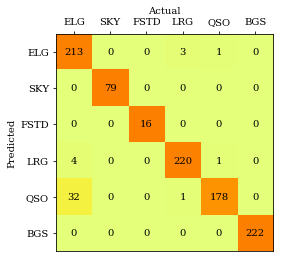

In [66]:
norm_cm = []
for i in cm:
    a = 0
    tmp_arr = []
    a = sum(i, 0)
    for j in i:
        tmp_arr.append(float(j)/float(a))
    norm_cm.append(tmp_arr)

fig = plt.figure()
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(np.array(norm_cm), cmap='Wistia',
                interpolation='nearest')

width, height = cm.shape

for x in xrange(width):
    for y in xrange(height):
        ax.annotate(str(cm[x][y]), xy=(y, x), 
                    color='k',
                    horizontalalignment='center',
                    verticalalignment='center')

# cb = fig.colorbar(res)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.xticks(range(width), objtypes[:width])
plt.yticks(range(height), objtypes[:height])
plt.xlabel('Actual')
plt.ylabel('Predicted')
# plt.savefig('plots/confusion_matrix.png', format='png', 
#             dpi=300, bbox_inches='tight')